In [1]:

import datetime
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import numpy as np
import requests

import pandas_datareader.data as web
from bs4 import BeautifulSoup
from datetime import datetime


import warnings
warnings.filterwarnings('ignore')

In [2]:
series_codes = {
    '1-Year Govt Bond Yield': 'V122541',
    '5-Year Govt Bond Yield': 'V122553',
    '10-Year Govt Bond Yield': 'V122543'
}

In [3]:
base_url = "https://www.bankofcanada.ca/valet/observations"

Data saved to canadian_bond_yields.csv


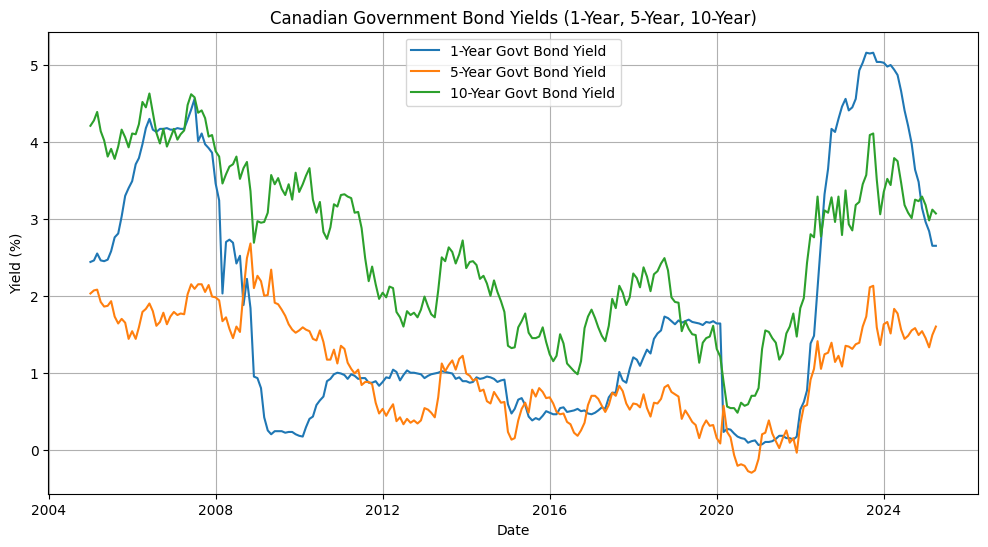


Most Recent Data (as of the latest available date):
            1-Year Govt Bond Yield  5-Year Govt Bond Yield  \
Date                                                         
2025-04-01                    2.65                     1.6   

            10-Year Govt Bond Yield  
Date                                 
2025-04-01                     3.07  


In [4]:
# Step 2: Function to download data for a given series
def download_boc_series(series_code):
    url = f"{base_url}/{series_code}/json"
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad responses
        data = response.json()
        
        # Extract observations (date and value pairs)
        observations = data['observations']
        dates = [obs['d'] for obs in observations]
        # Access the value using the series code and nested 'v' key
        values = [float(obs[series_code]['v']) if obs.get(series_code) and 'v' in obs[series_code] else None for obs in observations]
        
        # Create a DataFrame
        df = pd.DataFrame({
            'Date': pd.to_datetime(dates),
            series_code: values
        })
        df.set_index('Date', inplace=True)
        return df
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {series_code}: {e}")
        return None
    except (KeyError, TypeError) as e:
        print(f"Error processing {series_code}: {e} - Check the API response structure")
        return None

# Step 3: Download data for all series and merge into a single DataFrame
dataframes = []
for label, code in series_codes.items():
    print(f"Downloading {label} ({code})...")
    df = download_boc_series(code)
    if df is not None:
        df.rename(columns={code: label}, inplace=True)
        dataframes.append(df)

# Merge all DataFrames on the Date index
if dataframes:
    combined_data = dataframes[0]
    for df in dataframes[1:]:
        combined_data = combined_data.join(df, how='outer')
else:
    print("No data was downloaded successfully.")
    exit()

# Step 4: Clean and save the data
combined_data.dropna(how='all', inplace=True)  # Drop rows where all values are NaN
combined_data.sort_index(inplace=True)

# Save to CSV
output_file = "canadian_bond_yields.csv"
#combined_data.to_csv(output_file)
print(f"Data saved to {output_file}")

# Step 5: Visualize the data
plt.figure(figsize=(12, 6))
for column in combined_data.columns:
    plt.plot(combined_data.index, combined_data[column], label=column)

plt.title("Canadian Government Bond Yields (1-Year, 5-Year, 10-Year)")
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.show()

# Step 6: Print the most recent data
print("\nMost Recent Data (as of the latest available date):")
print(combined_data.tail(1))

In [5]:
combined_data.to_csv("bond_yield.csv")

Data saved to canadian_economic_data.csv


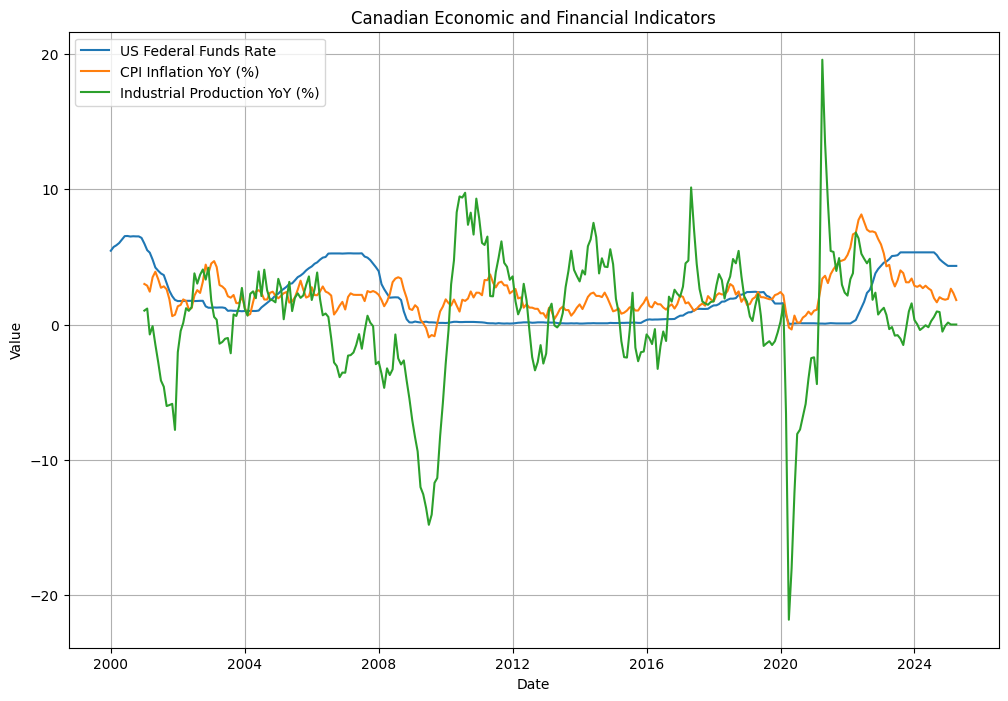

In [6]:


# Define date range
START_DATE = '2000-01-01'
END_DATE = '2025-05-15'  # Current date as of request


# Download data from FRED with Statistics Canada fallback for CPI
def download_fred_data(series_dict, start_date, end_date):
    data = {}
    for label, series in series_dict.items():
        print(f"Downloading {label} ({series}) from FRED...")
        try:
            df = web.DataReader(series, 'fred', start_date, end_date)
            data[label] = df[series]
        except Exception as e:
            print(f"Error downloading {series}: {e}")
            if label == 'CPI Index':
                print("Falling back to Statistics Canada API for CPI...")
                statcan_base_url = "https://www150.statcan.gc.ca/t1/wds/rest/getDataFromVectorsAndLatestNPeriods"
                vector_id = int('V41693271'.replace('V', ''))  # CPI All Items
                payload = [{"vectorId": vector_id, "latestN": 500}]
                try:
                    response = requests.post(statcan_base_url, json=payload)
                    response.raise_for_status()
                    statcan_data = response.json()
                    if statcan_data and statcan_data[0].get('vectorDataPoint'):
                        observations = statcan_data[0]['vectorDataPoint']
                        dates = [obs['refPer'] for obs in observations]
                        values = [obs['value'] for obs in observations]
                        cpi_data = pd.DataFrame({'Date': pd.to_datetime(dates), 'CPI': values}).set_index('Date')
                        data[label] = cpi_data['CPI']
                    else:
                        print(f"No data returned for CPI ({vector_id}). Response: {statcan_data}")
                except Exception as e:
                    print(f"Error downloading CPI from Statistics Canada: {e}")
                    print("Please manually download CPI data from Statistics Canada (Table 18-10-0004-01).")
            else:
                print(f"Please manually download {label} data from FRED or an alternative source.")
    return data

# Process FRED data (calculate YoY rates and policy differential)
def process_fred_data(fred_data):
    if not fred_data:
        print("No FRED data was downloaded successfully.")
        return pd.DataFrame()
    
    fred_combined = pd.DataFrame(fred_data)
    
    # Calculate YoY Inflation Rate
    if 'CPI Index' in fred_combined:
        fred_combined['CPI Inflation YoY (%)'] = fred_combined['CPI Index'].pct_change(periods=12) * 100
        fred_combined.drop(columns=['CPI Index'], inplace=True)
    
    # Calculate YoY growth rate for Industrial Production
    if 'Industrial Production Index' in fred_combined:
        fred_combined['Industrial Production YoY (%)'] = fred_combined['Industrial Production Index'].pct_change(periods=12) * 100
        fred_combined.drop(columns=['Industrial Production Index'], inplace=True)
    

    return fred_combined


# Download FRED data
fred_series = {
    'CPI Index': 'CANCPIALLMINMEI',  # For CPI Inflation YoY
    'Industrial Production Index': 'CANPROINDMISMEI',  # Monthly, Seasonally Adjusted
    'US Federal Funds Rate': 'FEDFUNDS'  # US Policy Rate, Monthly
}
fred_data = download_fred_data(fred_series, START_DATE, END_DATE)

# Process FRED data
combined_data = process_fred_data(fred_data)


# Clean and save data
combined_data.dropna(how='all', inplace=True)
combined_data.sort_index(inplace=True)
output_file = "canadian_economic_data.csv"
combined_data.to_csv(output_file)
print(f"Data saved to {output_file}")

# Visualize data
plt.figure(figsize=(12, 8))
for column in combined_data.columns:
    plt.plot(combined_data.index, combined_data[column], label=column)
plt.title("Canadian Economic and Financial Indicators")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

